<a href="https://colab.research.google.com/github/amarabuco/seriestemporais/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U statsmodels

# Imports

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [91]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
mpl.rcParams['figure.figsize'] = [20, 5]

In [6]:
from datetime import datetime
custom_time_parser = lambda x: datetime.strptime(x, "%H:%M:%S.%f").time() if '.' in x else datetime.strptime(x, "%H:%M:%S").time()

In [7]:
custom_time_parser('01:02:03.200000')

datetime.time(1, 2, 3, 200000)

In [8]:
custom_time_parser('01:02:04')

datetime.time(1, 2, 4)

In [9]:
train_orig = pd.read_csv('../dataset/case_28_subsampled_200ms_train.csv', parse_dates=['Time'], date_parser=custom_time_parser)
test = pd.read_csv('../dataset/case_28_subsampled_200ms_test.csv', parse_dates=['Time'], date_parser=custom_time_parser)
train_orig

,Time,EEG,BIS
0,00:00:00,NaN,NaN
1,00:00:00.200000,NaN,NaN
2,00:00:00.400000,NaN,NaN
3,00:00:00.600000,NaN,NaN
4,00:00:00.800000,NaN,NaN
...,...,...,...
16724,00:55:44.800000,0.01526,80.0
16725,00:55:45,0.01526,80.0
16726,00:55:45.200000,0.01526,80.0
16727,00:55:45.400000,5.99817,80.0


In [10]:
train_orig.index = train_orig['Time']
train_orig.drop(columns=['Time'], inplace=True)
test.index = test['Time']
test.drop(columns=['Time'], inplace=True)
train_orig

,EEG,BIS
Time,,
00:00:00,NaN,NaN
00:00:00.200000,NaN,NaN
00:00:00.400000,NaN,NaN
00:00:00.600000,NaN,NaN
00:00:00.800000,NaN,NaN
...,...,...
00:55:44.800000,0.01526,80.0
00:55:45,0.01526,80.0
00:55:45.200000,0.01526,80.0


## Validation Split (25%) = 1/3 of 75% of train set (the last 1/3)

In [11]:
25/(100*0.75)

0.3333333333333333

In [12]:
100*0.75*1/3

25.0

In [13]:
train = train_orig.iloc[:int(len(train_orig) * 2/3)]['EEG']
val = train_orig.iloc[int(len(train_orig) * 2/3):]['EEG']
test = test['EEG']

print(train.shape)
print(val.shape)

(11152,)
(5577,)


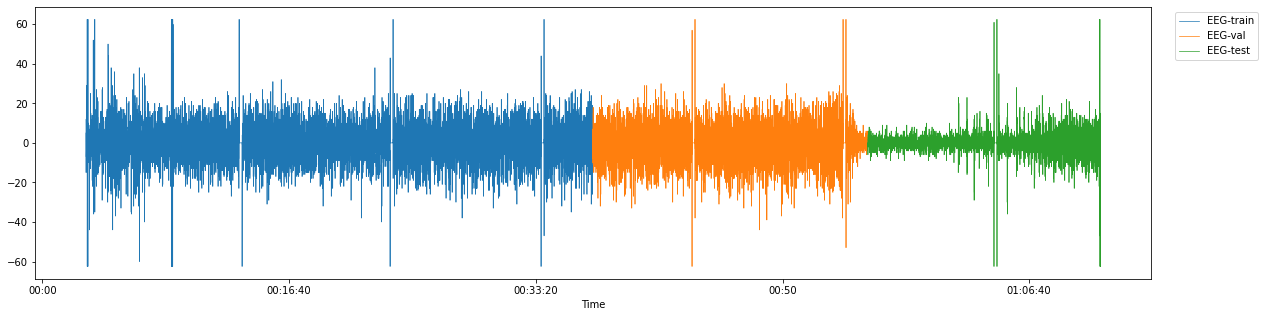

In [14]:
linewidth = 0.7
ax = train.rename(f'{train.name}-train').plot(linewidth = linewidth)
ax = val.rename(f'{train.name}-val').plot(ax=ax, linewidth = linewidth)
test.rename(f'{test.name}-test').plot(ax=ax, linewidth = linewidth)
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")

In [15]:
print(f'Train: {len(train.index)}')
print(f'Val: {len(val.index)}')
print(f'Test: {len(test.index)}')
total = len(train.index) + len(val.index) + len(test.index)
print(f'\nTrain: {len(train.index)/total*100:.3f}%')
print(f'Val: {len(val.index)/total*100:.3f}%')
print(f'Test: {len(test.index)/total*100:.3f}%')

Train: 11152
Val: 5577
Test: 5577

Train: 49.996%
Val: 25.002%
Test: 25.002%


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


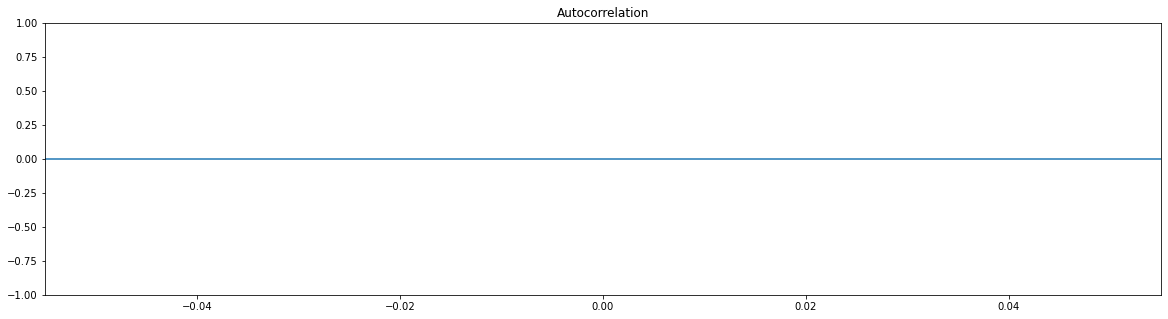

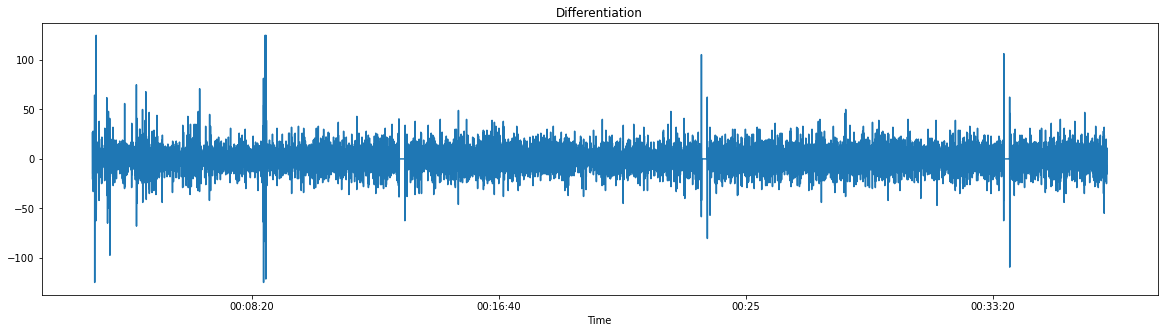

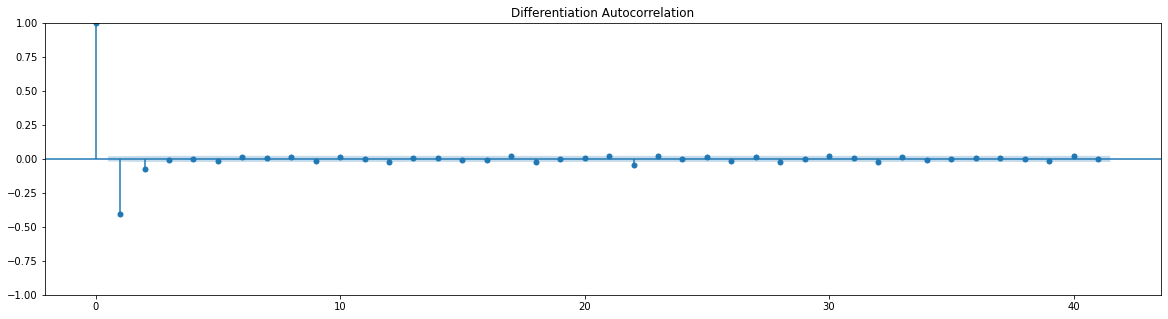

In [16]:
plot_acf(train);
plt.show()
train.diff().dropna().plot();
plt.title("Differentiation")
plt.show()
plot_acf(train.diff().dropna());
plt.title("Differentiation Autocorrelation")
plt.show()

### Análise

Filling not available data backward and forward

In [17]:
train = train.fillna(method='bfill').fillna(method='ffill')
train

Time
00:00:00            4.99084
00:00:00.200000     4.99084
00:00:00.400000     4.99084
00:00:00.600000     4.99084
00:00:00.800000     4.99084
                     ...   
00:37:09.400000   -15.00305
00:37:09.600000    -4.99084
00:37:09.800000    -4.99084
00:37:10            5.99817
00:37:10.200000    -8.98962
Name: EEG, Length: 11152, dtype: float64

<AxesSubplot:xlabel='Time'>

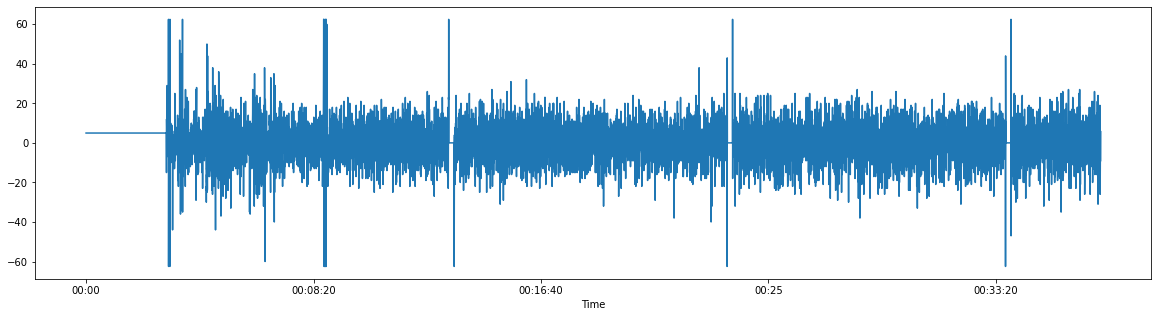

In [18]:
train.plot()

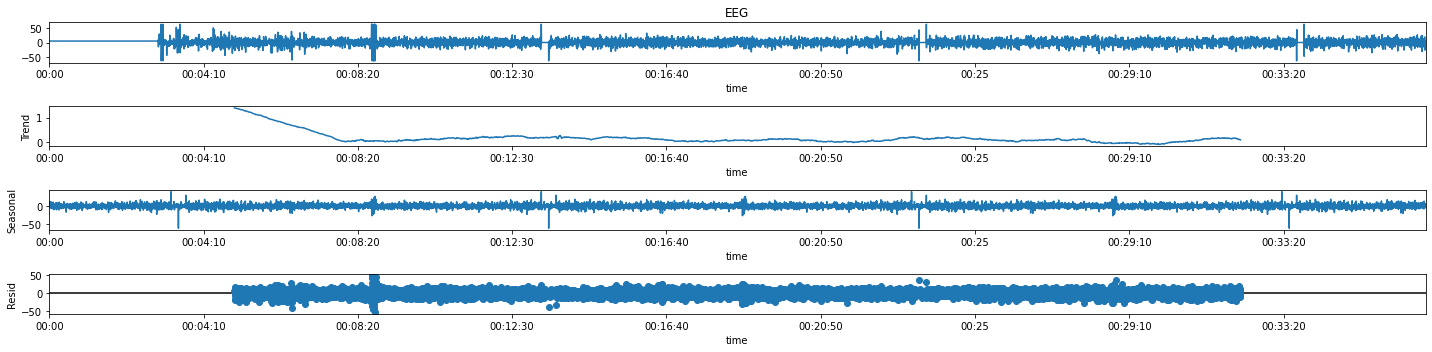

In [19]:
frequency = 200 # nanoseconds
minutes = 10 # 10 Minutes sazonality
train_decomp = tsa.seasonal_decompose(train, period=int(minutes*60*1000/frequency))
train_decomp.plot();

#### Stationarity

<AxesSubplot:xlabel='Time'>

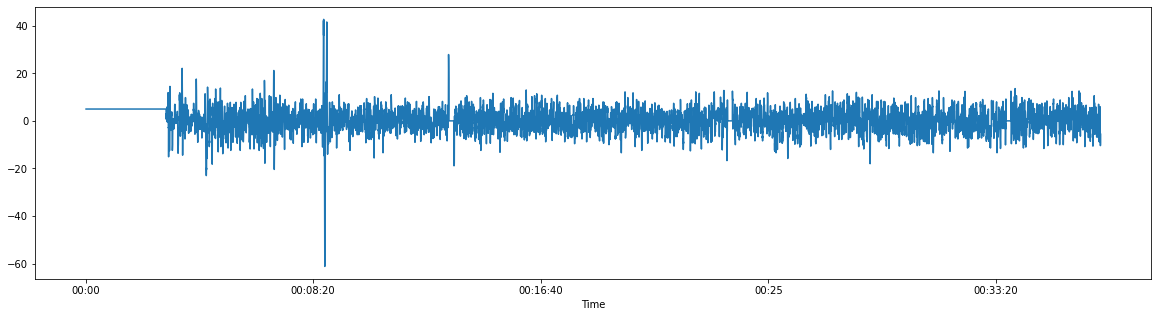

In [20]:
train.rolling(5).mean().plot()

<AxesSubplot:ylabel='Frequency'>

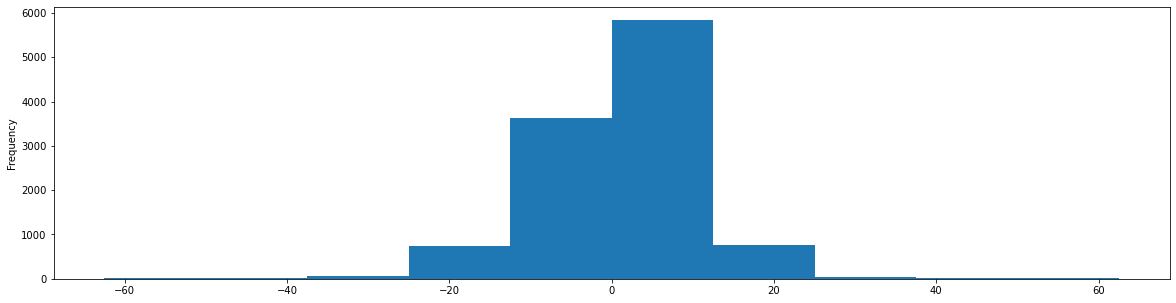

In [21]:
train.plot.hist()

#### Diferentiation 1st order (d)

<AxesSubplot:xlabel='Time'>

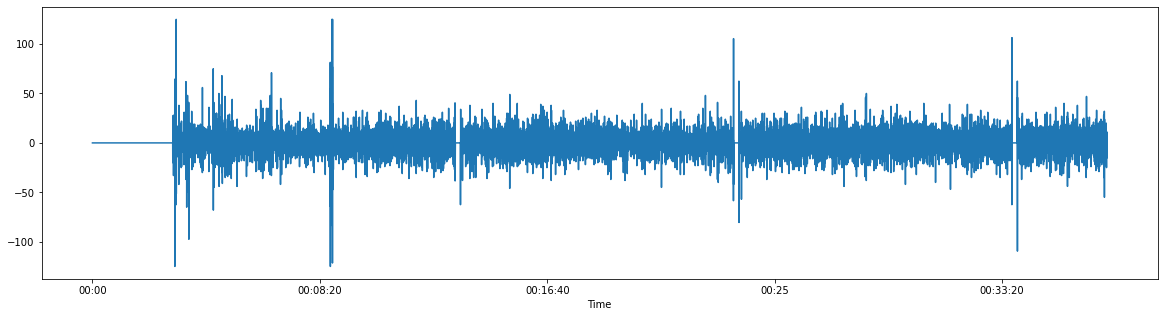

In [22]:
train.diff().plot()

<AxesSubplot:ylabel='Frequency'>

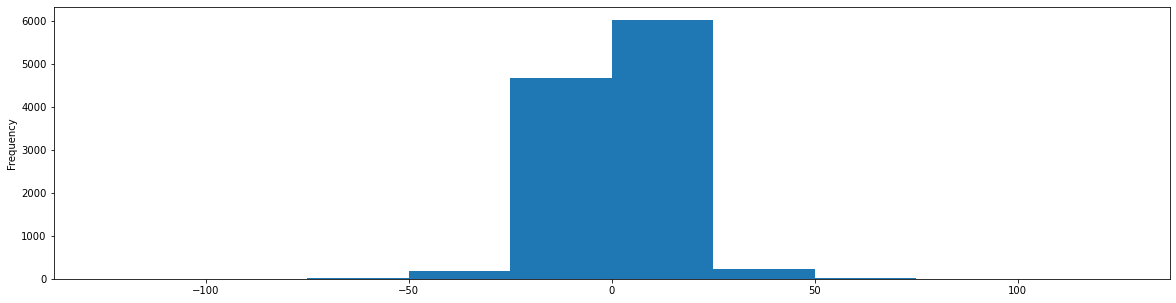

In [23]:
train.diff().plot.hist()

In [24]:
eegd1 = train.diff().dropna()

#### Autocorrelation

A correlation of a variable with itself at different times
is known as autocorrelation or serial correlation.

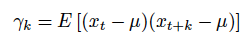

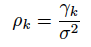

In [25]:
train.to_frame().corrwith(train.shift(-1))

EEG    0.162938
dtype: float64

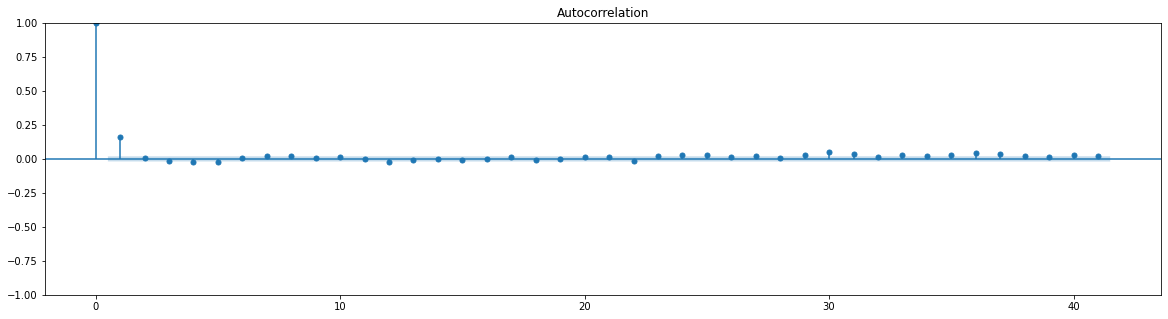

In [26]:
plot_acf(train);

In [27]:
train.to_frame().corrwith(eegd1.shift(-1))

EEG   -0.646931
dtype: float64

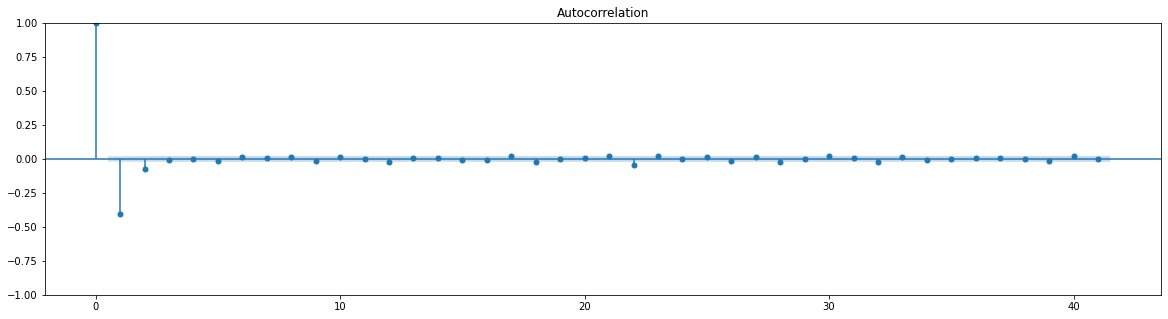

In [28]:
plot_acf(eegd1);

#### Partial Correlation

The partial autocorrelation at lag k is the correlation that
results after removing the effect of any correlations due to the terms at shorter
lags.

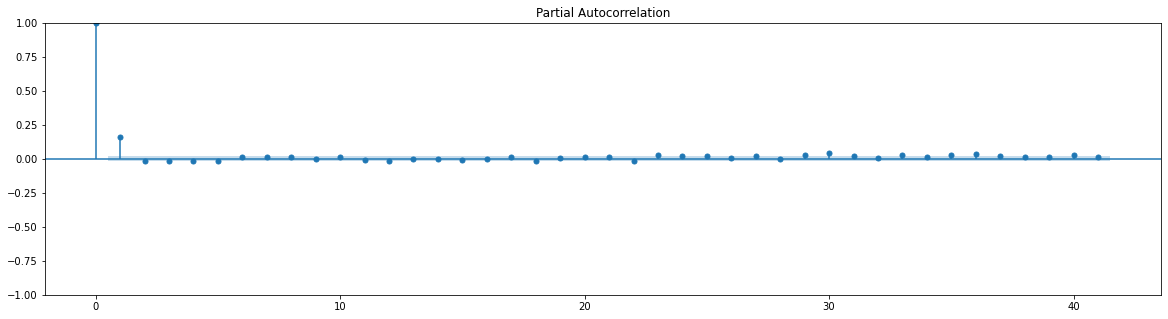

In [29]:
plot_pacf(train, method='ywm');

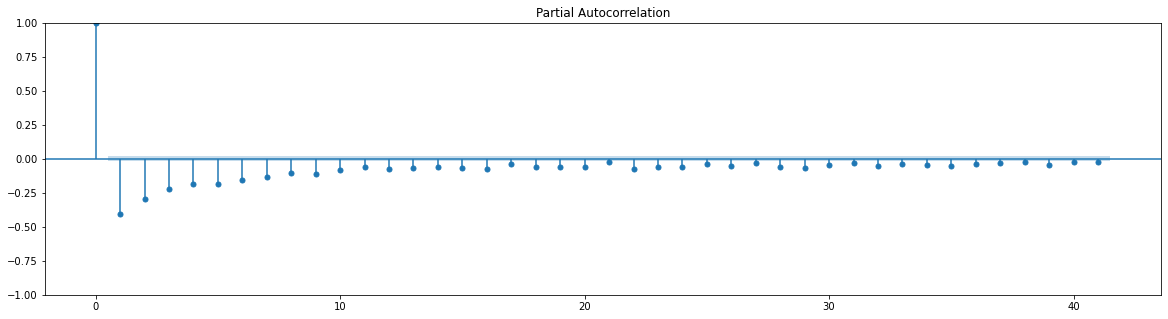

In [30]:
plot_pacf(eegd1, method='ywm');

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

### Feature Engineering

In [31]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [32]:
X_train = get_lags(train.to_frame(), 5)
X_val = get_lags(val.to_frame(), 5)
X_test = get_lags(test.to_frame(), 5)

In [33]:
X_train.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:00:01,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.200000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.400000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.600000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.800000,4.99084,4.99084,4.99084,4.99084,4.99084


In [34]:
X_val.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:37:11.400000,-4.99084,7.00549,-1.99939,-8.98962,-9.99695
00:37:11.600000,-7.00549,-4.99084,7.00549,-1.99939,-8.98962
00:37:11.800000,-8.01282,-7.00549,-4.99084,7.00549,-1.99939
00:37:12,-4.99084,-8.01282,-7.00549,-4.99084,7.00549
00:37:12.200000,-3.00671,-4.99084,-8.01282,-7.00549,-4.99084


In [35]:
X_test.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:55:46.800000,-1.99939,-1.99939,-5.99817,-3.00671,0.01526
00:55:47,0.01526,-1.99939,-1.99939,-5.99817,-3.00671
00:55:47.200000,4.01404,0.01526,-1.99939,-1.99939,-5.99817
00:55:47.400000,0.01526,4.01404,0.01526,-1.99939,-1.99939
00:55:47.600000,-1.99939,0.01526,4.01404,0.01526,-1.99939


In [36]:
y_train = train.to_frame().reindex(X_train.index)
y_val = val.to_frame().reindex(X_val.index)
y_test = test.to_frame().reindex(X_test.index)

In [37]:
y_train.head()

,EEG
Time,
00:00:01,4.99084
00:00:01.200000,4.99084
00:00:01.400000,4.99084
00:00:01.600000,4.99084
00:00:01.800000,4.99084


In [38]:
y_val.head()

,EEG
Time,
00:37:11.400000,-7.00549
00:37:11.600000,-8.01282
00:37:11.800000,-4.99084
00:37:12,-3.00671
00:37:12.200000,-5.99817


In [39]:
y_test.head()

,EEG
Time,
00:55:46.800000,0.01526
00:55:47,4.01404
00:55:47.200000,0.01526
00:55:47.400000,-1.99939
00:55:47.600000,1.99939


### KNN

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

Hyperparameters:

* K 
* weights
* distance

In [40]:
import numpy as np

In [41]:
print(f'Train size: {len(train.index.values)}')
print(f'Val size: {len(val.index.values)}')

Train size: 11152
Val size: 5577


In [42]:
X = pd.concat([X_train,X_val])
X

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:00:01,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.200000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.400000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.600000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.800000,4.99084,4.99084,4.99084,4.99084,4.99084
...,...,...,...,...,...
00:55:44.800000,-0.99206,-0.99206,0.99206,3.00671,0.01526
00:55:45,0.01526,-0.99206,-0.99206,0.99206,3.00671
00:55:45.200000,0.01526,0.01526,-0.99206,-0.99206,0.99206


In [43]:
X_train.index

Index([       00:00:01, 00:00:01.200000, 00:00:01.400000, 00:00:01.600000,
       00:00:01.800000,        00:00:02, 00:00:02.200000, 00:00:02.400000,
       00:00:02.600000, 00:00:02.800000,
       ...
       00:37:08.400000, 00:37:08.600000, 00:37:08.800000,        00:37:09,
       00:37:09.200000, 00:37:09.400000, 00:37:09.600000, 00:37:09.800000,
              00:37:10, 00:37:10.200000],
      dtype='object', name='Time', length=11147)

In [44]:
y = pd.concat([y_train,y_val])
y

,EEG
Time,
00:00:01,4.99084
00:00:01.200000,4.99084
00:00:01.400000,4.99084
00:00:01.600000,4.99084
00:00:01.800000,4.99084
...,...
00:55:44.800000,0.01526
00:55:45,0.01526
00:55:45.200000,0.01526


In [45]:
SEED = 42

In [46]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: %2.3f' % mse)
    return mse

def MAE(y_true,y_pred):    
     mae = mean_absolute_error(y_true, y_pred)
     print('MAE: %2.3f' % mae)
     return mae

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print('R2: %2.3f' % r2)
     return r2

def three_score(y_true,y_pred):    
    score = MAE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = R2(y_true,y_pred)
    score = MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    return score

def three_scorer():
    # return make_scorer(two_score, greater_is_better=True) # change for false if using MSE
    return make_scorer(three_score, greater_is_better=False) # change for false if using MSE


In [47]:
import random   

In [48]:
from sklearn.model_selection import PredefinedSplit
# Create a list where train data indices are -1 and validation data indices are 0 (2/3 = train and 1/3 = validation)
split_index = [-1 if index <= len(X)*2/3 else 0 for index in range(len(X))]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

for train_index, val_index in pds.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [49]:
def print_results_original_series(best_model, X_train, y_train, X_val, y_val, X_test, y_test):
    X_test = X_test.fillna(method='bfill').fillna(method='ffill')
    y_test = y_test.fillna(method='bfill').fillna(method='ffill')

    ax = None
    ax = y_train.rename(columns={'EEG': "train_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_train).flatten(), index=y_train.index, name="train_pred").plot(ax=ax, linewidth=linewidth)
    ax = y_val.rename(columns={'EEG': "val_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_val).flatten(), index=y_val.index, name="val_pred").plot(ax=ax, linewidth=linewidth)
    ax = y_test.rename(columns={'EEG': "test_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_test).flatten(), index=y_test.index, name="test_pred").plot(ax=ax, linewidth=linewidth)
    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")
    r2  = r2_score(best_model.predict(X_test), y_test)
    mse = mean_squared_error(best_model.predict(X_test), y_test)
    mae = mean_absolute_error(best_model.predict(X_test), y_test)
    print(f"Test R2: {r2}")
    print(f"Test mse: {mse}")
    print(f"Test mae: {mae}")

In [58]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from scipy.stats import uniform

def train_validate_model(model, X_train_val, y_train_val, X_test, y_test, model_name=None, distributions={}, repetitions=10,
                        print_result=print_results_original_series):

    results = []
    best_models = []
    
    # Create a list where train data indices are -1 and validation data indices are 0 (2/3 = train and 1/3 = validation)
    split_index = [-1 if index <= len(X)*2/3 else 0 for index in range(len(X))]

    # Use the list to create PredefinedSplit
    pds = PredefinedSplit(test_fold = split_index)

    for train_index, val_index in pds.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    for repetition in range(repetitions):
        print(f"Repetition: {str(repetition)}")
        SEED = random.seed(repetition)
        randGridS = RandomizedSearchCV(model, param_distributions=distributions, random_state = SEED, scoring=three_scorer(), 
                                       cv=pds, n_jobs=-1, verbose=2, return_train_score=True)
        res = randGridS.fit(X, y)
        best_params = res.best_params_
        best_model = res.best_estimator_
        best_score = res.best_score_
        r2  = r2_score(best_model.predict(X_val), y_val)
        mse = mean_squared_error(best_model.predict(X_val), y_val)
        mae = mean_absolute_error(best_model.predict(X_val), y_val)
        print(f"Best params: {best_params}")
        print(f"R2: {r2}")
        print(f"mse: {mse}")
        print(f"mae: {mae}")
        print()

        best_models.append(res)
        results.append({'model': model_name,
                        'repetition': repetition,
                        'val_r2': r2,
                        'val_mse': mse, 
                        'val_mae': mae,
                        'params': best_params})
        
    dataframe = pd.DataFrame(results).sort_values(['val_r2', 'val_mse', 'val_mae'], ascending=[False, True, True])
    print(f"Best params of all repetitions: {dataframe.iloc[0].params}")
    # SEED = random.seed(dataframe.iloc[0].repetition)
    best_model = clone(model).set_params(**dataframe.iloc[0].params)
    best_model.fit(X, y)
    ax = None
    linewidth = 2

    print_result(best_model, X_train, y_train, X_val, y_val, X_test, y_test)
    return best_model, dataframe
    

In [63]:
distributions = {'n_neighbors':  [int(x) for x in np.linspace(start = 1, stop = 1000, num = 100)],
                 'weights': ['uniform', 'distance']}

In [64]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

In [67]:
resultados = pd.DataFrame([])

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 303}
R2: 0.9832068100157922
mse: 1.4395328478507399
mae: 0.03722519662197009

Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 253}
R2: 0.9831327069351697
mse: 1.4458223361609281
mae: 0.03351223592198712

Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 182}
R2: 0.9830213551378533
mse: 1.4553260216542634
mae: 0.02910230083896721

Repetition: 3
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 445}
R2: 0.9832068100157922
mse: 1.4395328478507399
mae: 0.03722519662197009

Repetition: 4
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 273}
R2: 0.9832089890363896
mse: 1.439348606368362
ma

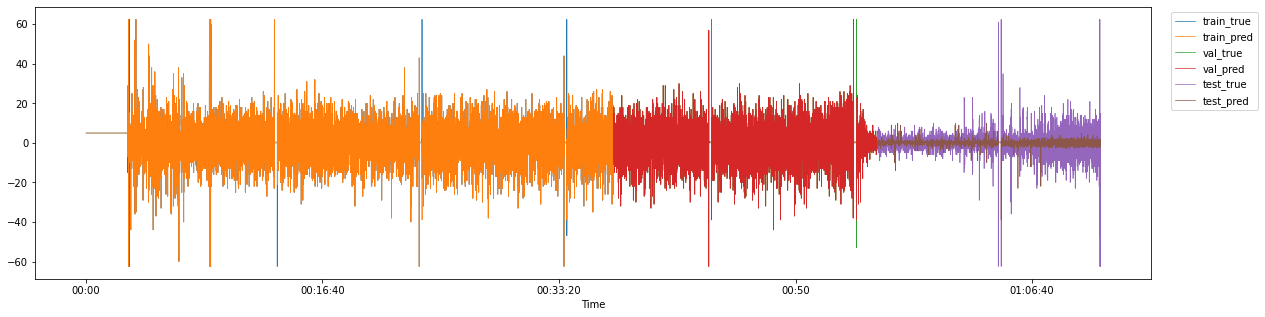

In [66]:
best_model_knn, resultados_knn = train_validate_model(model, X, y, X_test, y_test, 'KNN', distributions)

In [ ]:
resultados_knn

,model,repetition,val_r2,val_mse,val_mae,params
0,KNN,0,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
1,KNN,1,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
2,KNN,2,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
4,KNN,4,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
7,KNN,7,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
9,KNN,9,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
3,KNN,3,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
5,KNN,5,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
6,KNN,6,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
8,KNN,8,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"


In [68]:
resultados = pd.concat([resultados, resultados_knn])
resultados

,model,repetition,val_r2,val_mse,val_mae,params
4,KNN,4,0.983209,1.439349,0.037350,"{'weights': 'distance', 'n_neighbors': 273}"
0,KNN,0,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 303}"
3,KNN,3,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
5,KNN,5,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
7,KNN,7,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
9,KNN,9,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
6,KNN,6,0.983137,1.445448,0.033710,"{'weights': 'distance', 'n_neighbors': 243}"
1,KNN,1,0.983133,1.445822,0.033512,"{'weights': 'distance', 'n_neighbors': 253}"
2,KNN,2,0.983021,1.455326,0.029102,"{'weights': 'distance', 'n_neighbors': 182}"
8,KNN,8,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"


E agora?

In [69]:
X_d1 = X.diff().fillna(method='bfill').fillna(method='ffill')
y_d1 = y.diff().fillna(method='bfill').fillna(method='ffill')
X_test_d1 = X_test.diff().fillna(method='bfill').fillna(method='ffill')
y_test_d1 = y_test.diff().fillna(method='bfill').fillna(method='ffill')

In [71]:
def print_results_diff_series(best_model, X_train, y_train, X_val, y_val, X_test, y_test):
    X_test = X_test.fillna(method='bfill').fillna(method='ffill')
    y_test = y_test.fillna(method='bfill').fillna(method='ffill')

    ax = None
    ax = y_train.rename(columns={'EEG': "train_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_train).flatten(), index=y_train.index, name="train_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    ax = y_val.rename(columns={'EEG': "val_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_val).flatten(), index=y_val.index, name="val_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    ax = y_test.rename(columns={'EEG': "test_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_test).flatten(), index=y_test.index, name="test_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")
    r2  = r2_score(best_model.predict(X_test), y_test)
    mse = mean_squared_error(best_model.predict(X_test), y_test)
    mae = mean_absolute_error(best_model.predict(X_test), y_test)
    print(f"Test R2: {r2}")
    print(f"Test mse: {mse}")
    print(f"Test mae: {mae}")

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 434}
R2: -90.42136357733229
mse: 176.99501468163618
mae: 10.008442799708414

Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 233}
R2: -78.4478634862927
mse: 177.2406480553909
mae: 10.01508211432783

Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 253}
R2: -80.35652551068111
mse: 177.20095089895494
mae: 10.015233820135604

Repetition: 3
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 344}
R2: -86.12950708623957
mse: 177.03715742693797
mae: 10.012792071969667

Repetition: 4
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 656}
R2: -99.66313746072764
mse: 176.83805303582608
mae: 9.9

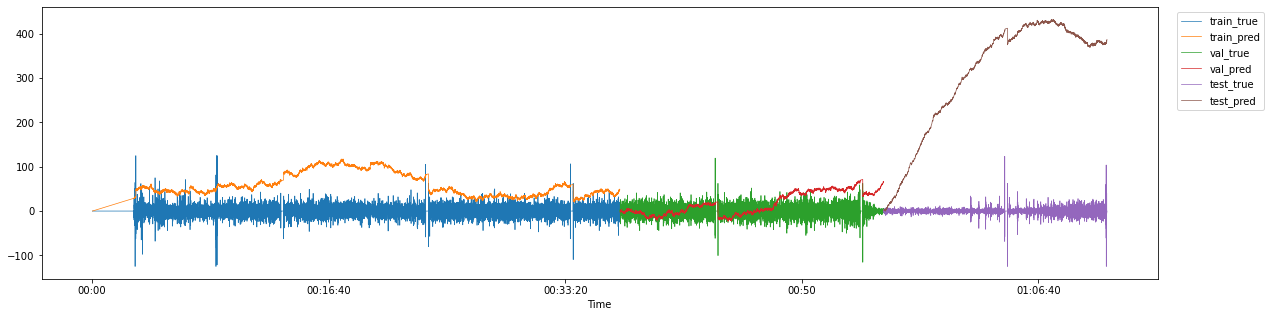

In [72]:
neighd1 = KNeighborsRegressor()

res_neigh_d1, resultados_neigh_d1 = train_validate_model(neighd1, X_d1, y_d1, X_test_d1, y_test_d1, 'KNN_d1', distributions,
                                                         print_result=print_results_diff_series)

In [73]:
resultados = pd.concat([resultados,resultados_neigh_d1])
resultados

,model,repetition,val_r2,val_mse,val_mae,params
4,KNN,4,0.983209,1.439349,0.037350,"{'weights': 'distance', 'n_neighbors': 273}"
0,KNN,0,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 303}"
3,KNN,3,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
5,KNN,5,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
7,KNN,7,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
9,KNN,9,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
6,KNN,6,0.983137,1.445448,0.033710,"{'weights': 'distance', 'n_neighbors': 243}"
1,KNN,1,0.983133,1.445822,0.033512,"{'weights': 'distance', 'n_neighbors': 253}"
2,KNN,2,0.983021,1.455326,0.029102,"{'weights': 'distance', 'n_neighbors': 182}"
8,KNN,8,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"


Qual o problema dessa previsão?

 * Erro acumulado (problema em multi step recursivo)

In [74]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(res_neigh_d1.predict(X_test_d1).flatten(), name='EEG'), axis=0)

In [75]:
pred_one

,EEG
0,NaN
1,1.511440
2,4.391284
3,-1.181773
4,-2.424149
...,...
4710,-25.563442
4711,0.934770
4712,0.839047
4713,-0.171528


In [76]:
y_train

,EEG
Time,
00:00:01,4.99084
00:00:01.200000,4.99084
00:00:01.400000,4.99084
00:00:01.600000,4.99084
00:00:01.800000,4.99084
...,...
00:37:09.400000,-15.00305
00:37:09.600000,-4.99084
00:37:09.800000,-4.99084


In [77]:
pred_one.EEG

0             NaN
1        1.511440
2        4.391284
3       -1.181773
4       -2.424149
          ...    
4710   -25.563442
4711     0.934770
4712     0.839047
4713    -0.171528
4714     0.755784
Name: EEG, Length: 4715, dtype: float64

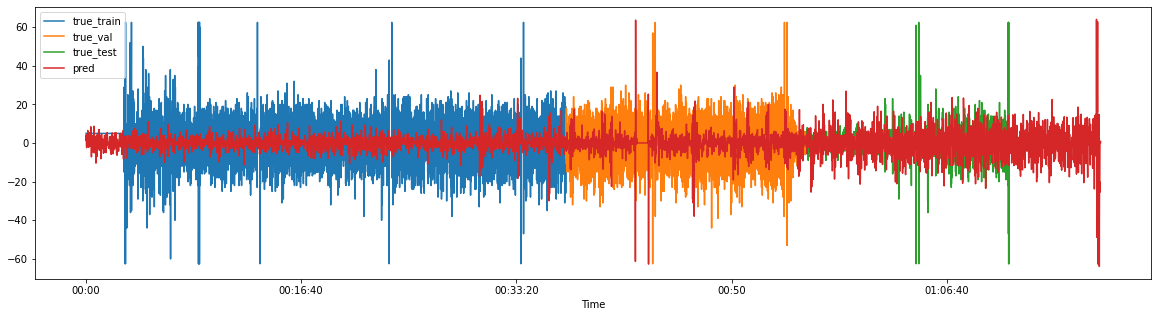

In [78]:
ax = None
ax = y_train.EEG.rename('true_train').plot(ax=ax)
ax = y_val.EEG.rename('true_val').plot(ax=ax)
ax = y_test.EEG.rename('true_test').plot(ax=ax)
ax = pred_one.EEG.rename('pred').plot(ax=ax, label='pred')
plt.legend()

In [79]:
pred_one

,EEG
0,NaN
1,1.511440
2,4.391284
3,-1.181773
4,-2.424149
...,...
4710,-25.563442
4711,0.934770
4712,0.839047
4713,-0.171528


In [80]:
resultados

,model,repetition,val_r2,val_mse,val_mae,params
4,KNN,4,0.983209,1.439349,0.037350,"{'weights': 'distance', 'n_neighbors': 273}"
0,KNN,0,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 303}"
3,KNN,3,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
5,KNN,5,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
7,KNN,7,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
9,KNN,9,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
6,KNN,6,0.983137,1.445448,0.033710,"{'weights': 'distance', 'n_neighbors': 243}"
1,KNN,1,0.983133,1.445822,0.033512,"{'weights': 'distance', 'n_neighbors': 253}"
2,KNN,2,0.983021,1.455326,0.029102,"{'weights': 'distance', 'n_neighbors': 182}"
8,KNN,8,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"


In [81]:
print('EEG pred_one - KNN model Results')
y_test = y_test.fillna(method='bfill').fillna(method='ffill')
pred_one = pred_one.fillna(method='bfill').fillna(method='ffill')
print(r2_score(pred_one, y_test))
print(mean_squared_error(pred_one, y_test))
print(mean_absolute_error(pred_one, y_test))


EEG pred_one - KNN model Results
-0.8302465056164652
67.01499777397599
4.794101873426608


In [82]:
residuos = res_neigh_d1.predict(X_d1).flatten() - y_d1.reset_index(drop=True).values.flatten()

<AxesSubplot:>

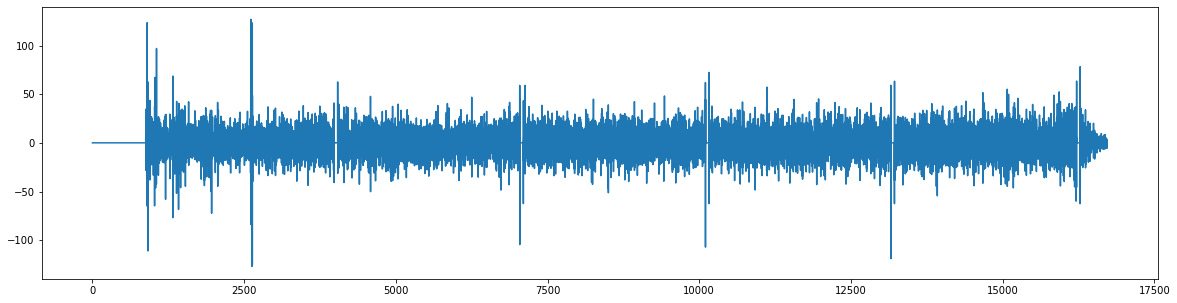

In [83]:
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

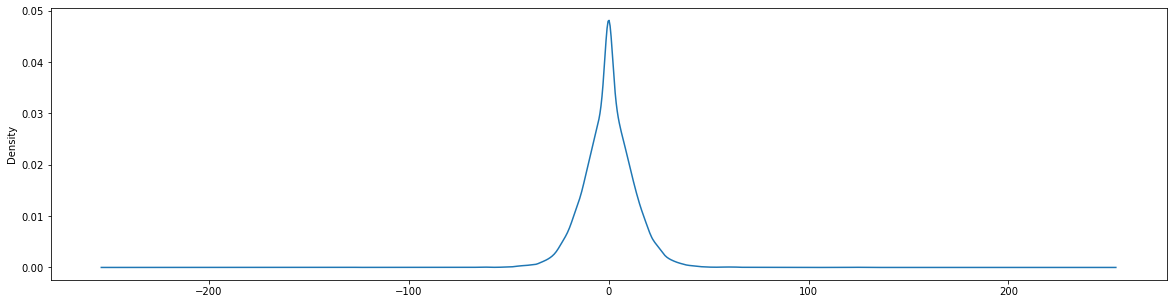

In [84]:
pd.Series(residuos).plot.kde()

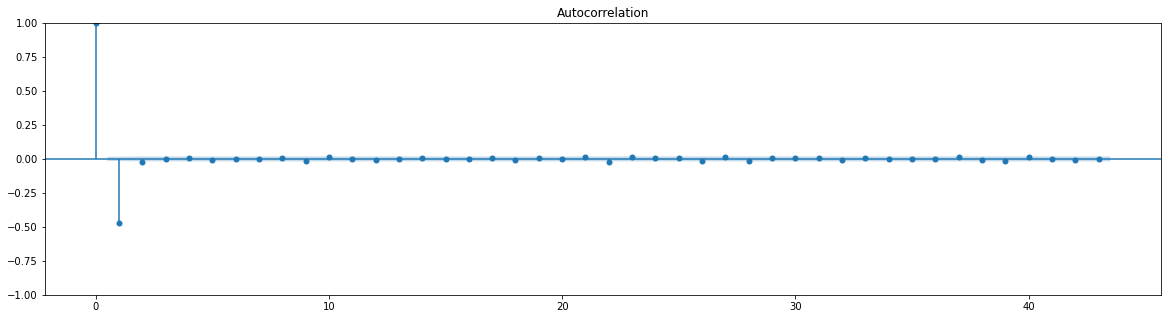

In [85]:
plot_acf(residuos);

### SVR

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR

In [86]:
distributions = {'C': [x for x in np.linspace(start = 1, stop = 10, num = 100)],
                 'epsilon': [x for x in np.linspace(start = .1, stop = 1, num = 100)],
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [87]:
from sklearn.svm import SVR

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.7272727272727272, 'C': 2.090909090909091}
R2: -36.12605341695686
mse: 85.32228745572414
mae: 6.874623016870508

Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.6818181818181818, 'C': 5.090909090909091}
R2: -29.921201301473605
mse: 84.48261838747054
mae: 6.830466675755213

Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.8090909090909091, 'C': 5.181818181818182}
R2: -29.7826584929185
mse: 84.42352373078675
mae: 6.832846071492545

Repetition: 3
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.3909090909090909, 'C': 1.3636363636363638}
R2: -38.94651746363965
mse: 85.67940239164737
mae: 6.8889181407488005

Repetition: 4
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.6727272727272727, 'C': 2.6363636363636367}
R2: -34.817515406169285
mse: 85.16411365184041
mae: 6.862273378007885

Repetition: 5
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.26363636363636367, 'C': 4.454545454545455}
R2: -30.25377986086788
mse: 84.76620331337168
mae: 6.831950130926867

Repetition: 6
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.19090909090909092, 'C': 3.272727272727273}
R2: -32.228405591853786
mse: 85.1071099048573
mae: 6.847349101832004

Repetition: 7
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.2727272727272727, 'C': 4.818181818181818}
R2: -29.86630316556689
mse: 84.67260873547644
mae: 6.827450558179713

Repetition: 8
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.7818181818181817, 'C': 3.909090909090909}
R2: -31.705587319210927
mse: 84.74180012410048
mae: 6.846525593201778

Repetition: 9
Fitting 1 folds for each of 10 candidates, totalling 10 fits


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {'kernel': 'rbf', 'epsilon': 0.4181818181818182, 'C': 5.454545454545455}
R2: -29.122262818057063
mse: 84.45723154289236
mae: 6.823221155324661

Best params of all repetitions: {'kernel': 'rbf', 'epsilon': 0.4181818181818182, 'C': 5.454545454545455}


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test R2: -28.08929454996452
Test mse: 32.02394361012353
Test mae: 3.2868086581257434


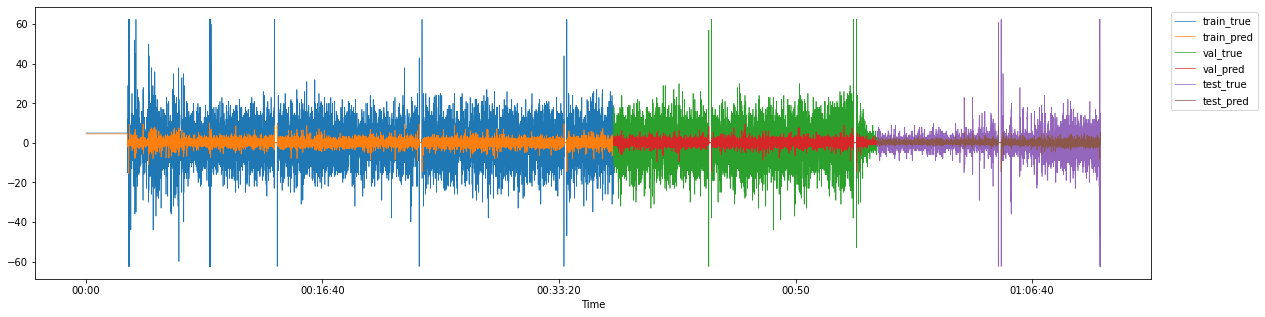

In [88]:
best_svr_model, resultados_svr = train_validate_model(SVR(), X, y, X_test, y_test, 'SVR', distributions)

In [ ]:
resultados = pd.concat([resultados, resultados_svr])


In [93]:
resultados.reset_index(drop=True)

,model,repetition,val_r2,val_mse,val_mae,params
0,KNN,4,0.983209,1.439349,0.037350,"{'weights': 'distance', 'n_neighbors': 273}"
1,KNN,0,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 303}"
2,KNN,3,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
3,KNN,5,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
4,KNN,7,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 323}"
5,KNN,9,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
6,KNN,6,0.983137,1.445448,0.033710,"{'weights': 'distance', 'n_neighbors': 243}"
7,KNN,1,0.983133,1.445822,0.033512,"{'weights': 'distance', 'n_neighbors': 253}"
8,KNN,2,0.983021,1.455326,0.029102,"{'weights': 'distance', 'n_neighbors': 182}"
9,KNN,8,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"


In [90]:
resultados.to_csv('resultados.csv', index=False)